# Text Clustering - Classic4 dataset
    CACM: 3204 documents
    CISI: 1460 documents
    CRAN: 1398 documents
    MED : 1033 documents

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sps
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Reading data
* We convert the tf-idf data to a Compressed Sparse Row format (CSR)

In [2]:
terms = pd.read_csv(os.getcwd()+'/data/terms_detailed.txt', header=None, sep=' ').values
documents = pd.read_csv(os.getcwd()+'/data/documents.txt', header=None, sep=' ').values
true_k = len(np.unique(documents[:,1]))

#['docID','wordID','count']
tfidf = pd.read_csv(os.getcwd()+'/data/docbyterm.tfidf.norm.txt', header=None, sep=' ', skiprows=1).values
rows, row_pos = np.unique(tfidf[:, 0], return_inverse=True)
cols, col_pos = np.unique(tfidf[:, 1], return_inverse=True)
pivot_table = sps.coo_matrix((tfidf[:, 2], (row_pos, col_pos)),
                             shape=(len(rows), len(cols)))
pivot_table = pivot_table.tocsr()

labels = documents[np.array(rows, dtype=int)-1,1]

## 2. LSA + K-means Clustering
* Find the best number of components to apply LSA using v-measure.
* Mini batch k-means.

Components: 20, variance explained: 0.0897, v-measure: 0.677
Components: 40, variance explained: 0.1328, v-measure: 0.684
Components: 60, variance explained: 0.1664, v-measure: 0.814
Components: 80, variance explained: 0.1956, v-measure: 0.721
Components: 100, variance explained: 0.2217, v-measure: 0.688
Components: 120, variance explained: 0.2457, v-measure: 0.618
Components: 140, variance explained: 0.2676, v-measure: 0.652
Components: 160, variance explained: 0.2883, v-measure: 0.691
Components: 180, variance explained: 0.3076, v-measure: 0.634
Components: 200, variance explained: 0.3256, v-measure: 0.587
Components: 220, variance explained: 0.3431, v-measure: 0.724
Components: 240, variance explained: 0.3597, v-measure: 0.617
Components: 260, variance explained: 0.3756, v-measure: 0.688
Components: 280, variance explained: 0.3905, v-measure: 0.681
Components: 300, variance explained: 0.4052, v-measure: 0.554
Components: 320, variance explained: 0.4192, v-measure: 0.625
Components: 

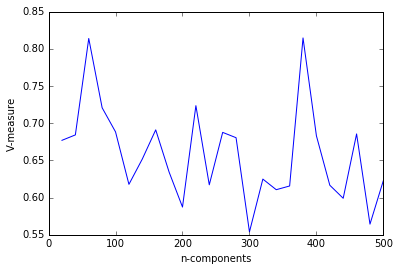

In [4]:
best_v_measure = 0
best_n_components = 0
h_components, h_v_measure = [], []
normalizer = Normalizer(copy=False)

for n_components in range(20,501,20):
    svd = TruncatedSVD(n_components)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(pivot_table)
    km = MiniBatchKMeans(n_clusters=true_k)
    #km = KMeans(n_clusters=true_k)
    km.fit(X)
    explained_variance = svd.explained_variance_ratio_.sum()
    v_measure = metrics.v_measure_score(labels, km.labels_)
    h_components.append(n_components)
    h_v_measure.append(v_measure)
    if v_measure > best_v_measure:
        best_v_measure = v_measure
        best_n_components = n_components
        best_svd = svd
        best_km = km
    print("Components: %i, variance explained: %.4f, v-measure: %.3f"
          % (n_components, explained_variance, v_measure))
                             
print("\nBest number of components: %i\nAchieved v-measure: %.3f" % (best_n_components, best_v_measure))
print()
plt.plot(h_components, h_v_measure)
plt.xlabel('n-components')
plt.ylabel('V-measure')
print("\nHomogeneity: %0.3f" % metrics.homogeneity_score(labels, best_km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, best_km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, best_km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, best_km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, best_km.labels_, sample_size=1000))

print()

## 3. Most representative words on clusters

The 10 most representative words for each cluster/label (K-means)



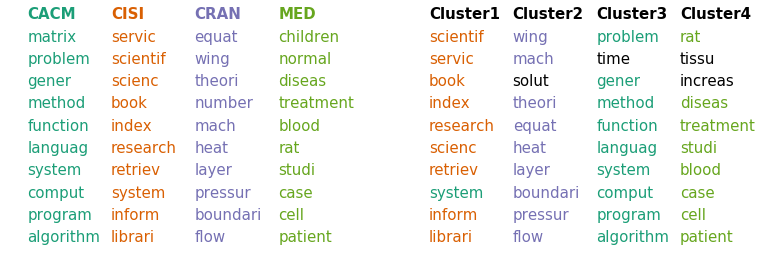

In [271]:
n_words = 10
words_clusters = np.zeros([true_k,n_words], dtype=np.object)
words_labels = np.zeros([true_k,n_words], dtype=np.object)
print("The %d most representative words for each cluster/label (K-means)\n" % n_words)
original_space_centroids = best_svd.inverse_transform(best_km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
for i in range(true_k):
    for j,ind in enumerate(order_centroids[i, :n_words]):
        words_clusters[i,j] = terms[ind,1]
    
dense_table = pivot_table.todense()
unique_groups = np.unique(documents[:,1])
sums = np.zeros([4,5896])
for i, group in enumerate(unique_groups):
    sums[i] = (dense_table[labels == group]).sum(axis=0)
order_real_labels = sums.argsort()[:, ::-1]
for i in unique_groups:
    for j,ind in enumerate(order_real_labels[i, :n_words]):
        words_labels[i,j] = terms[ind,1]
    
fig = plt.figure()
ax = fig.add_subplot(111)
cluster_colors = ['#1b9e77', '#d95f02', '#7570b3', '#66a61e']

def getColor(word):
    for i,words in enumerate(words_labels):
        if len(words[words==word]) == 1:
            return cluster_colors[i]
    return 'black'       

for x,words,words_c in zip(range(true_k),words_labels,words_clusters):
    for y,word,word_c in zip(range(n_words),words,words_c):
        ax.text(x*0.25, y*0.1, word,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes,
                color=cluster_colors[x], fontsize=15)
        ax.text(1.2+(x*0.25), y*0.1, word_c,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes,
                color=getColor(word_c), fontsize=15)

for i,label in enumerate(['CACM', 'CISI', 'CRAN', 'MED']):
    ax.text(i*0.25, n_words*0.1, label,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes, fontweight='bold',
                color=cluster_colors[i], fontsize=15)
    ax.text(1.2+(i*0.25), n_words*0.1, ("Cluster%d" % (i+1)),
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes, fontweight='bold', fontsize=15)
    
plt.axis('off')
plt.show()

## 4. Hierarchical clustering

In [269]:
n_components = 10

time0 = time()
h_clustering = AgglomerativeClustering(n_clusters=true_k)
svd = TruncatedSVD(n_components)
lsa = make_pipeline(svd, normalizer)
X = lsa.fit_transform(pivot_table)
h_clustering.fit(X)
print("Time elapsed: %.2f seconds." % (time()-time0))
print("\nHomogeneity: %0.3f" % metrics.homogeneity_score(labels, h_clustering.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, h_clustering.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, h_clustering.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, h_clustering.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, h_clustering.labels_, sample_size=1000))

Time elapsed: 114.35 seconds.

Homogeneity: 0.647
Completeness: 0.705
V-measure: 0.675
Adjusted Rand-Index: 0.480
Silhouette Coefficient: 0.317


The 10 most representative words for each cluster/label (Hierarchical clustering)



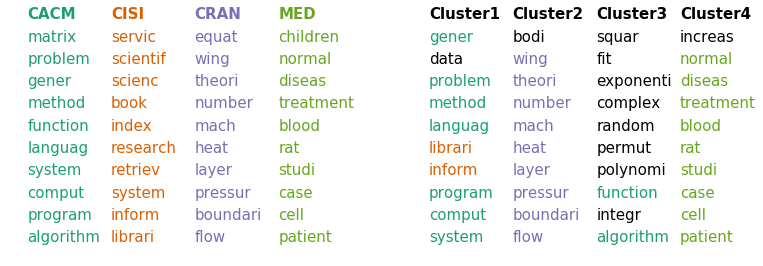

In [272]:
words_clusters_h = np.zeros([true_k,n_words], dtype=np.object)
sums = np.zeros([4,5896])
for i, group in enumerate(unique_groups):
    sums[i] = (dense_table[h_clustering.labels_ == group]).sum(axis=0)
order_real_labels = sums.argsort()[:, ::-1]
for i in unique_groups:        
    for j,ind in enumerate(order_real_labels[i, :n_words]):
        words_clusters_h[i,j] = terms[ind,1]
        
print("The %d most representative words for each cluster/label (Hierarchical clustering)\n" % n_words)
    
fig = plt.figure()
ax = fig.add_subplot(111)

for x,words,words_c in zip(range(true_k),words_labels,words_clusters_h):
    for y,word,word_c in zip(range(n_words),words,words_c):
        ax.text(x*0.25, y*0.1, word,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes,
                color=cluster_colors[x], fontsize=15)
        ax.text(1.2+(x*0.25), y*0.1, word_c,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes,
                color=getColor(word_c), fontsize=15)

for i,label in enumerate(['CACM', 'CISI', 'CRAN', 'MED']):
    ax.text(i*0.25, n_words*0.1, label,
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes, fontweight='bold',
                color=cluster_colors[i], fontsize=15)
    ax.text(1.2+(i*0.25), n_words*0.1, ("Cluster%d" % (i+1)),
                verticalalignment='bottom', horizontalalignment='left',
                transform=ax.transAxes, fontweight='bold', fontsize=15)
    
plt.axis('off')
plt.show()